In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import gzip
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.2.0
sys.version_info(major=3, minor=6, micro=4, releaselevel='final', serial=0)
matplotlib 2.1.2
numpy 1.19.1
pandas 0.22.0
sklearn 0.19.1
tensorflow 2.2.0
tensorflow.keras 2.3.0-tf


In [2]:
def load_data():
  """Loads the Fashion-MNIST dataset.

  This is a dataset of 60,000 28x28 grayscale images of 10 fashion categories,
  along with a test set of 10,000 images. This dataset can be used as
  a drop-in replacement for MNIST. The class labels are:

  | Label | Description |
  |:-----:|-------------|
  |   0   | T-shirt/top |
  |   1   | Trouser     |
  |   2   | Pullover    |
  |   3   | Dress       |
  |   4   | Coat        |
  |   5   | Sandal      |
  |   6   | Shirt       |
  |   7   | Sneaker     |
  |   8   | Bag         |
  |   9   | Ankle boot  |

  Returns:
      Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.

      **x_train, x_test**: uint8 arrays of grayscale image data with shape
        (num_samples, 28, 28).

      **y_train, y_test**: uint8 arrays of labels (integers in range 0-9)
        with shape (num_samples,).

  License:
      The copyright for Fashion-MNIST is held by Zalando SE.
      Fashion-MNIST is licensed under the [MIT license](
      https://github.com/zalandoresearch/fashion-mnist/blob/master/LICENSE).

  """
  dirname = os.path.join('datasets', 'fashion-mnist')
  # 数据下载到本地，提供一个本地的文件夹地址
  base = 'data/'
  # base = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/'
  files = [
      'train-labels-idx1-ubyte.gz', 'train-images-idx3-ubyte.gz',
      't10k-labels-idx1-ubyte.gz', 't10k-images-idx3-ubyte.gz'
  ]

  paths = [base + f_name for f_name in files]
  # for fname in files:
  #   paths.append(get_file(fname, origin=base + fname, cache_subdir=dirname))

  with gzip.open(paths[0], 'rb') as lbpath:
    y_train = np.frombuffer(lbpath.read(), np.uint8, offset=8)

  with gzip.open(paths[1], 'rb') as imgpath:
    x_train = np.frombuffer(
        imgpath.read(), np.uint8, offset=16).reshape(len(y_train), 28, 28)

  with gzip.open(paths[2], 'rb') as lbpath:
    y_test = np.frombuffer(lbpath.read(), np.uint8, offset=8)

  with gzip.open(paths[3], 'rb') as imgpath:
    x_test = np.frombuffer(
        imgpath.read(), np.uint8, offset=16).reshape(len(y_test), 28, 28)

  return (x_train, y_train), (x_test, y_test)

In [3]:
# fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [6]:
# x = (x-u) / std
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# x_train:[None, 28, 28] -> [None, 784]
x_train_scaled = scaler.fit_transform(x_train.astype(np.float32).reshape(-1,1)).reshape(-1, 28, 28)
x_valid_scaled = scaler.transform(x_valid.astype(np.float32).reshape(-1,1)).reshape(-1, 28, 28)
x_test_scaled = scaler.transform(x_test.astype(np.float32).reshape(-1,1)).reshape(-1, 28, 28)



In [4]:
# tf.keras.models.Sequential()
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

# relu: y = max(0, x)
# softmax: 将向量变成概率分布. x = [x1, x2, x3], 
#          y = [e^x1/sum, e^x2/sum, e^x3/sum], sum = e^x1 + e^x2 + e^x3

# reason for sparse: y->index. y->one_hot->[] 
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = "sgd",
              metrics = ["accuracy"])

下面主要针对callbacks的一些常见参数进行设置，此处我们主要针对Tensorboard, earlystopping, ModelCheckpoint这三个常用的参数进行设置。各个参数的解释如下：

tf.keras.callbacks.TensorBoard，tensorflow提供的可视化工具，主要用于以下方面的可视化展示：
- 指标摘要图
- 训练图可视化
- 激活直方图
- 采样分析
tf.keras.callbacks.EarlyStopping，对模型训练的关键指标进行监控，主要是对一下三个指标进行监控：
monitor	验证集上目标函数的值.
min_delta	Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
patience	Number of epochs with no improvement after which training will be stopped.


In [14]:
# Tensorboard, earlystopping, ModelCheckpoint
logdir = './callbacks'  # 保存文件目录
if not os.path.exists(logdir):
    os.mkdir(logdir)
outout_model_file = os.path.join(logdir, "fashion_mnist_model.h5")  # 输出保存模型文件

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(outout_model_file, save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3),
]

history = model.fit(x_train_scaled, y_train, epochs=10, validation_data=(x_valid_scaled, y_valid),
                   callbacks=callbacks)

Epoch 1/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0867 - accuracy: 0.9707 - val_loss: 0.3423 - val_accuracy: 0.8954
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0839 - accuracy: 0.9718 - val_loss: 0.3424 - val_accuracy: 0.8942
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0801 - accuracy: 0.9731 - val_loss: 0.3522 - val_accuracy: 0.8884
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0777 - accuracy: 0.9744 - val_loss: 0.3425 - val_accuracy: 0.8972
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0759 - accuracy: 0.9752 - val_loss: 0.3407 - val_accuracy: 0.9002
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0721 - accuracy: 0.9767 - val_loss: 0.3496 - val_accuracy: 0.9002
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0693 - accuracy: 0.9773 - val_loss: 0.3852 - val_accuracy:

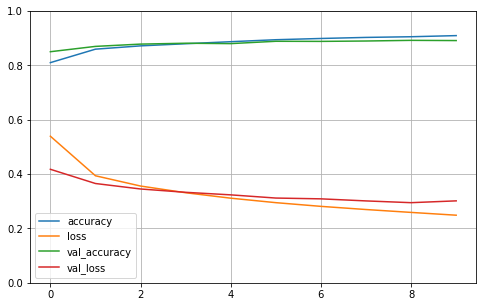

In [9]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()
    
plot_learning_curves(history)

In [10]:
model.evaluate(x_test_scaled, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3389 - accuracy: 0.8780


[0.33886468410491943, 0.878000020980835]